In [1]:
import os
os.chdir('/Users/yuukilp/Documents/repo/GraphLSurv/S02-modeling')

In [2]:
import pandas as pd
import numpy as np

ds_name = 'tcga_brca'
path_data_csv = './data_split/tcga_brca/TCGA_BRCA_path_full.csv'
#ds_name = 'tcga_brca'
#path_data_csv = './data_split/tcga_brca/TCGA_BRCA_path_full.csv'

data_csv = pd.read_csv(path_data_csv, dtype={"patient_id": str})

data_csv.head()

,pathology_id,patient_id,e,t
0,TCGA-A1-A0SE-01Z-00-DX1.04B09232-C6C4-46EF-AA2...,TCGA-A1-A0SE,0,1321
1,TCGA-E2-A1LK-01Z-00-DX1.5EBAA1F4-F1B4-4938-A51...,TCGA-E2-A1LK,1,266
2,TCGA-A2-A0CQ-01Z-00-DX1.4E5FB4E5-A08C-4C87-A3B...,TCGA-A2-A0CQ,0,2695
3,TCGA-UU-A93S-01Z-00-DX1.C4809779-DF5F-4F5D-A78...,TCGA-UU-A93S,1,116
4,TCGA-AN-A0AS-01Z-00-DX1.51E551E9-E5F4-4C94-9B2...,TCGA-AN-A0AS,0,10


In [3]:
data_pat = data_csv.drop_duplicates(subset=['patient_id'], keep='first').loc[:, ['patient_id', 'e', 't']]
data_pat = data_pat.reset_index(drop=True)
print(len(data_pat))

978


## Validate the data splitting

In [4]:
def get_patient_data(pids):
    sel_data = data_csv[data_csv['patient_id'].isin(pids)]
    sel_data = sel_data.drop_duplicates(subset=['patient_id'], keep='first')
    sel_data = sel_data.loc[:, ['patient_id', 'e', 't']]
    return sel_data

import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

%matplotlib inline

def plot_KM_curves(data_list, label_list, show_pvalue, filepath_save):
    fig, ax = plt.subplots(figsize=(10, 8))
    ds_list = []
    t_col, e_col = 't', 'e'

    kmfhs = []
    for i, ds in enumerate(data_list):
        ds_list.append(ds)
        kmfh = KaplanMeierFitter()
        kmfh.fit(ds[t_col], event_observed=ds[e_col], label=label_list[i])
        kmfh.survival_function_.plot(ax=ax)
        kmfhs.append(kmfh)
    
    if show_pvalue:
        combs = [(0,1), (0,2), (1,2)]
        for c in combs:
            results = logrank_test(ds_list[c[0]][t_col], ds_list[c[1]][t_col],
                       ds_list[c[0]][e_col], ds_list[c[1]][e_col], alpha=0.95)

            logrank_p = results.p_value
            print("Logrank ({} VS. {}) = {}".format(label_list[c[0]], label_list[c[1]], logrank_p))

    ax.set_xlabel("Observed Time (month)")
    ax.set_ylabel("Survival Probalities")
    ax.legend(loc="upper right")

#train = 588, #val = 195, #test = 195
Logrank (train VS. val) = 0.9764102379669071
Logrank (train VS. test) = 0.9781641751815255
Logrank (val VS. test) = 0.967793676737831
#train = 588, #val = 195, #test = 195
Logrank (train VS. val) = 0.979089657433513
Logrank (train VS. test) = 0.9838915014611125
Logrank (val VS. test) = 0.9559473755035686
#train = 588, #val = 195, #test = 195
Logrank (train VS. val) = 0.9487431125047044
Logrank (train VS. test) = 0.9532475107676478
Logrank (val VS. test) = 0.9571530164656485
#train = 588, #val = 195, #test = 195
Logrank (train VS. val) = 0.984812285057916
Logrank (train VS. test) = 0.9668403730204895
Logrank (val VS. test) = 0.9910758293299906
#train = 588, #val = 195, #test = 195
Logrank (train VS. val) = 0.990147193169491
Logrank (train VS. test) = 0.9487535948134781
Logrank (val VS. test) = 0.9940524993143732


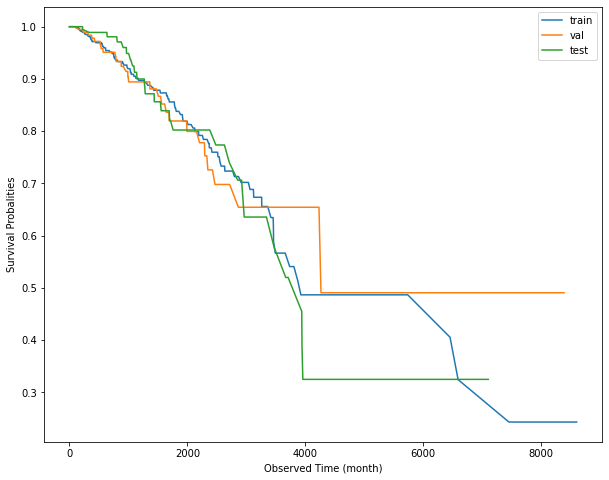

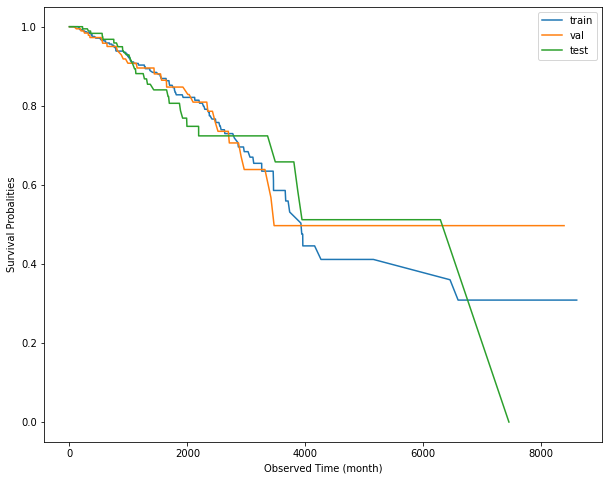

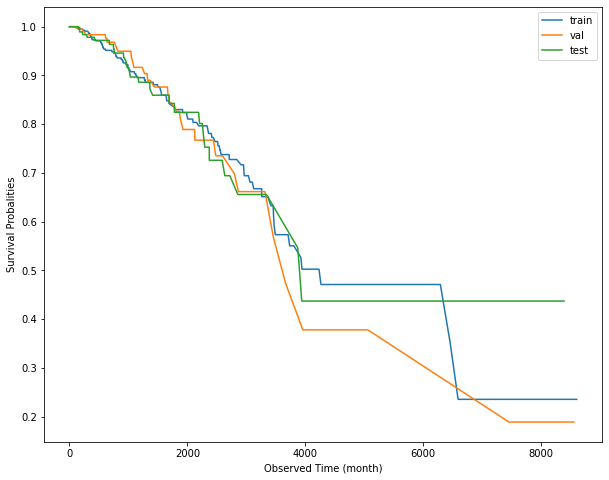

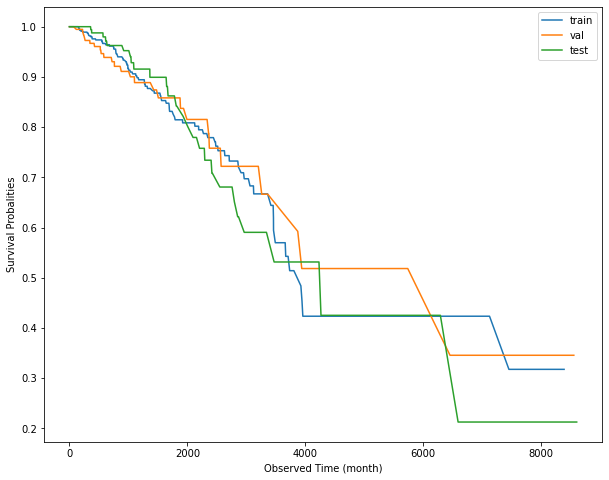

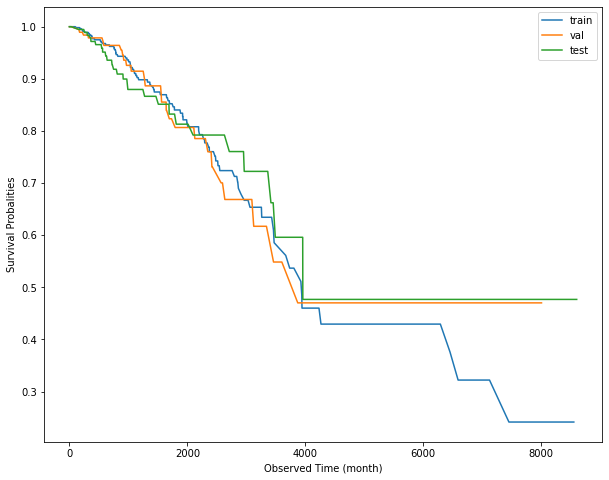

In [5]:
for SEED in [360, 568, 630, 788, 850]:
    path_data_npz = './data_split/new/{}-seed{}.npz'.format(ds_name, SEED)
    data_npz = np.load(path_data_npz)

    train_pids = [str(s) for s in data_npz['train_patients']]
    val_pids = [str(s) for s in data_npz['val_patients']]
    test_pids = [str(s) for s in data_npz['test_patients']]

    train_pat = get_patient_data(train_pids)
    val_pat = get_patient_data(val_pids)
    test_pat = get_patient_data(test_pids)

    print("#train = {}, #val = {}, #test = {}".format(len(train_pat), len(val_pat), len(test_pat)))
    plot_KM_curves([train_pat, val_pat, test_pat], ['train', 'val', 'test'], True, '')

## Generate the patients splitting

In [8]:
SMALL_NUMERIC_FLOAT = 1e-5

class DataSplit(object):
    """docstring for DataSplit"""
    def __init__(self, exp_type, test_ratio=0.2, val_ratio=0.2, kfold=5):
        super(DataSplit, self).__init__()
        self.exp_type = exp_type
        self.test_ratio = test_ratio
        self.val_ratio = val_ratio
        self.kfold = kfold
        assert exp_type in ['sim', 'std-hpopt', 'std-perfm']

    def __call__(self, n, stratify=None):
        if stratify is None:
            return self.split_perm(n)
        else:
            stratify = np.array(stratify)
            
            y0_idx   = np.where(stratify == 0)[0]
            y0_split = self.split_perm(y0_idx.shape[0])
            y1_idx   = np.where(stratify == 1)[0]
            y1_split = self.split_perm(y1_idx.shape[0])

            if self.exp_type == 'sim':
                ret = []
                for i in range(3):
                    cur_idx = np.append(y0_idx[y0_split[i]], y1_idx[y1_split[i]])
                    np.random.shuffle(cur_idx)
                    ret.append(cur_idx)
                return ret
            elif self.exp_type == 'std-perfm':
                ret = []
                for i in range(2):
                    cur_idx = np.append(y0_idx[y0_split[i]], y1_idx[y1_split[i]])
                    np.random.shuffle(cur_idx)
                    ret.append(cur_idx)
                return ret
            elif self.exp_type == 'std-hpopt':
                res_fold = []
                for i in range(self.kfold):
                    fold_idx = []
                    for j in range(2):
                        cur_idx = np.append(y0_idx[y0_split[i][j]], y1_idx[y1_split[i][j]])
                        np.random.shuffle(cur_idx)
                        fold_idx.append(cur_idx)
                    res_fold.append(fold_idx)
                return res_fold

    def split_perm(self, n):
        nperm = np.random.permutation(n)
        if self.exp_type == 'sim':
            n_train = int(np.around(n * (1 - self.test_ratio)) + SMALL_NUMERIC_FLOAT)
            n_test  = n - n_train
            n_val   = int(np.around(n_train * self.val_ratio) + SMALL_NUMERIC_FLOAT)
            n_train = n_train - n_val
            return nperm[:n_train], nperm[n_train:(n_train+n_val)], nperm[(n_train+n_val):]
        elif self.exp_type == 'std-perfm':
            n_train = int(np.around(n * (1 - self.test_ratio)) + SMALL_NUMERIC_FLOAT)
            n_test  = n - n_train
            return nperm[:n_train], nperm[n_train:]
        elif self.exp_type == 'std-hpopt':
            n_train = int(np.around(n * (1 - self.test_ratio)) + SMALL_NUMERIC_FLOAT)
            n_fold = int(np.ceil(n_train / self.kfold) + SMALL_NUMERIC_FLOAT)
            res_fold = []
            for i in range(self.kfold):
                fold_val_idx = nperm[(i*n_fold):min(n_train, (i+1)*n_fold)]
                fold_train_idx = np.append(nperm[:(i*n_fold)], nperm[min(n_train, (i+1)*n_fold):n_train])
                res_fold.append([fold_train_idx, fold_val_idx])
            return res_fold


from lifelines.statistics import logrank_test
def check_partition(ds_list, thr):
    t_col = 't'
    e_col = 'e'
    combs = [(0,1), (0,2), (1,2)]
    res_p = []
    for c in combs:
        results = logrank_test(ds_list[c[0]][t_col], ds_list[c[1]][t_col],
                       ds_list[c[0]][e_col], ds_list[c[1]][e_col], alpha=0.95)

        logrank_p = results.p_value
        res_p.append(logrank_p)
        if logrank_p < thr:
            return False
    print(res_p)
    return True

def get_patient_data(pids):
    sel_data = data_csv[data_csv['patient_id'].isin(pids)]
    sel_data = sel_data.drop_duplicates(subset=['patient_id'], keep='first')
    sel_data = sel_data.loc[:, ['patient_id', 'e', 't']]
    return sel_data

In [11]:
for SEED in [360, 568, 630, 788, 850]:
    np.random.seed(SEED)

    label = list(data_pat['e'])
    spliter = DataSplit('sim', test_ratio=0.2, val_ratio=0.25)

    train_idx, val_idx, test_idx = spliter(len(data_pat), stratify=label)
    train_idx = list(train_idx)
    val_idx = list(val_idx)
    test_idx = list(test_idx)
    
    train_ids = list(data_pat.loc[train_idx, :]['patient_id'])
    val_ids = list(data_pat.loc[val_idx, :]['patient_id'])
    test_ids = list(data_pat.loc[test_idx, :]['patient_id'])
    
    train_pat = get_patient_data(train_ids)
    val_pat = get_patient_data(val_ids)
    test_pat = get_patient_data(test_ids)
    
    if check_partition([train_pat, val_pat, test_pat], 0.94):
        print("Seed {} passed testing".format(SEED))
        np.savez('./data_split/new/{}-seed{}.npz'.format(ds_name, SEED), 
            train_patients=train_ids, val_patients=val_ids, test_patients=test_ids)

[0.9764102379669071, 0.9781641751815255, 0.967793676737831]
Seed 360 passed testing
[0.979089657433513, 0.9838915014611125, 0.9559473755035686]
Seed 568 passed testing
[0.9487431125047044, 0.9532475107676478, 0.9571530164656485]
Seed 630 passed testing
[0.984812285057916, 0.9668403730204895, 0.9910758293299906]
Seed 788 passed testing
[0.990147193169491, 0.9487535948134781, 0.9940524993143732]
Seed 850 passed testing
